In [3]:
# Importing necessary libraries for image processing, model creation, and data manipulation
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
def url_extractor10(photo_file, save_folder, species, originals=False, limit=None, isresearch=False):
    photos = pd.read_csv(photo_file)
    os.makedirs(save_folder, exist_ok=True)
    attributions = []

    headers = {"Cache-Control": "no-cache", "Pragma": "no-cache", "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"}

    while species:
        selected_species = species.pop(0)

        filtered_photos = photos[
            (photos["license"].isin(["CC-BY-NC", "CC-BY", "CC-BY-SA", "CC0", "CC-BY-NC-ND"])) &
            (photos["quality_grade"] == "research" if isresearch else True) &
            (photos["scientific_name"].str.contains(selected_species))
        ]

        count = 0
        for index, row in filtered_photos.iterrows():
            if limit is not None and count >= limit:
                break

            image_url = str(row['image_url']) # 12:34
            if originals and ("medium.jpg" in image_url):
                image_url = image_url.replace("medium", "original")
            else:
              continue

            response = requests.get(image_url, headers=headers, stream=True)
            if response.status_code == 200:
                img_path = os.path.join(save_folder, f"{selected_species}{count + 1}.jpg")
                with open(img_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                if pd.notna(row["user_name"]):
                    attributions.append(str(row["user_name"]) + f": {selected_species}{count + 1}.jpg")
                else:
                    attributions.append("User " + str(row["user_id"]) + f": {selected_species}{count + 1}.jpg")
                count += 1

    return attributions

In [4]:
# Mount Google Drive to access datasets stored there
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/MyDrive/Orchid_csvs/platanthera_species/species'
data_directory = pathlib.Path(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Define image batch size and dimensions for processing
batch_size = 32
img_height, img_width = 180, 180

# Load training and validation datasets with image resizing
train_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,  # Split the data into training and validation
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2395 files belonging to 9 classes.
Using 1916 files for training.
Found 2395 files belonging to 9 classes.
Using 479 files for validation.


In [7]:
# Construct the model with convolutional layers and dense layers for classification
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values
    layers.Conv2D(16, 3, padding='same', activation='relu'),  # Convolutional layer for feature extraction
    layers.MaxPooling2D(),  # Max pooling to reduce dimensionality
    layers.Conv2D(32, 3, padding='same', activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),  # Flattening the output for dense layers
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(len(train_data.class_names))  # Output layer with softmax activation for classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile the model by specifying the optimizer, loss function, and metrics to track
model.compile(
    optimizer='adam',  # Optimizer that adjusts weights during training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function for multi-class classification
    metrics=['accuracy']  # Track the accuracy during training
)


In [9]:
# Train the model on the training data and validate it on the validation set
epochs = 10  # Number of training epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3050 - loss: 1.8978 - val_accuracy: 0.5574 - val_loss: 1.2344
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.5956 - loss: 1.1229 - val_accuracy: 0.5511 - val_loss: 1.1860
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6607 - loss: 0.9125 - val_accuracy: 0.6430 - val_loss: 0.9823
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7503 - loss: 0.7147 - val_accuracy: 0.6493 - val_loss: 1.0514
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8366 - loss: 0.4952 - val_accuracy: 0.6388 - val_loss: 1.1704
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.8968 - loss: 0.3257 - val_accuracy: 0.6347 - val_loss: 1.2366
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9504 - loss: 0.1607 - val_accuracy: 0.6576 - val_loss: 1.3542
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.9523 - loss: 0.1529 - val_accuracy: 0.6534 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


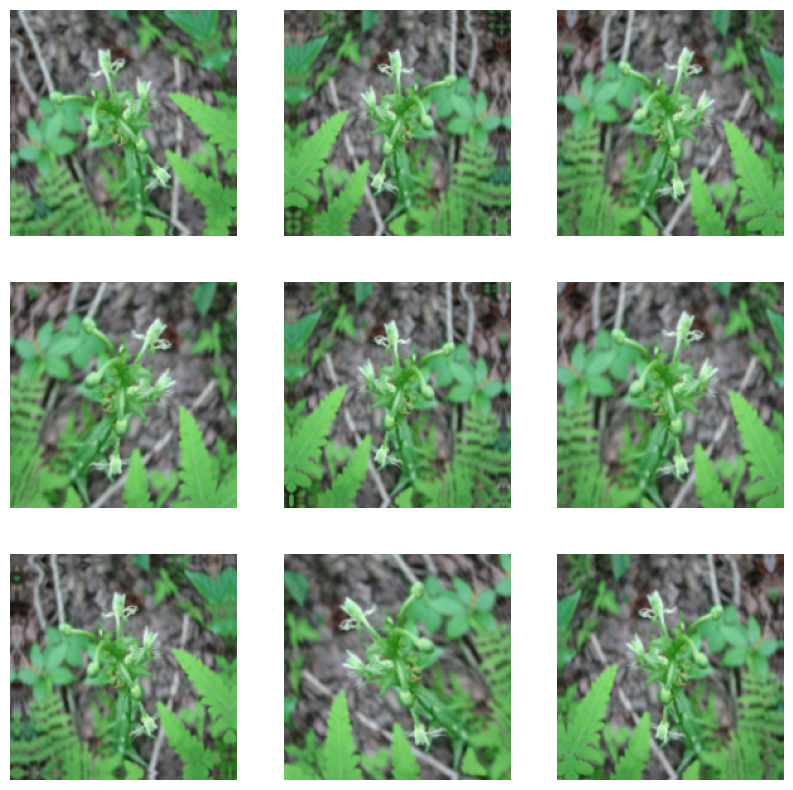

In [11]:
# Apply data augmentation to enhance the model's ability to generalize
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Preview augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [28]:
# Predict an image using the trained model
image_path = pathlib.Path("/content/drive/MyDrive/Orchidtest/leucomac.jpg")
img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Print predicted class with confidence score
for i, class_name in enumerate(train_data.class_names):
    print(f"{class_name}: {100 * score[i]:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
blephariglottis: 0.00%
clavellata: 0.00%
integra: 0.00%
integrilabia: 0.00%
lacera: 0.01%
nivea: 0.00%
oranges: 0.00%
prairies: 99.90%
purples: 0.09%


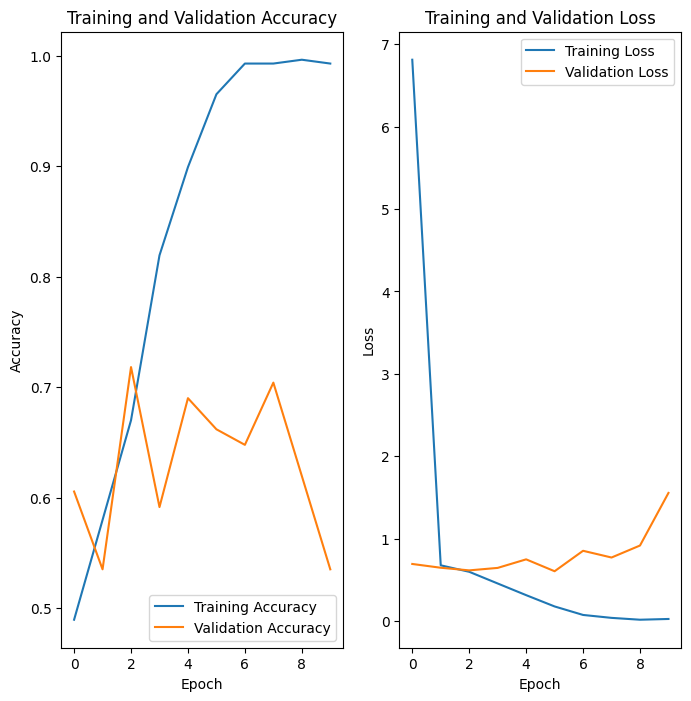

In [ ]:
# Plot the training and validation accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
# Save the trained model for later use
model.save('/content/drive/MyDrive/saved_models/platanthera_model2.keras')
